In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [44]:
data = pd.read_csv('processed_train (5).csv')
data

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119947,0.552153,0.666667,0.531401,7.0,0,53447.0,1.0,1.0,1,21,...,0,1,0,0,0,0,0,0,0,1
119948,0.552153,0.530941,0.542553,7.0,0,53447.0,1.0,1.0,1,141,...,0,1,0,0,0,0,1,0,0,1
119949,0.448751,0.420644,0.484434,7.0,0,42588.0,2.0,1.0,1,207,...,0,1,0,0,0,0,1,0,0,1
119950,0.493175,0.530941,0.537931,7.0,0,53447.0,1.0,1.0,1,68,...,0,1,0,0,0,0,1,0,0,1


Разобьем выборку на тест и трейн

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучи LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавь шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here

pipe_lr= Pipeline([('lr_scaler', MinMaxScaler()), 
                    ('lr_estimator', LogisticRegression())])

pipe_svm = Pipeline([('lr_scaler', MinMaxScaler()), 
                    ('svm_estimator', LinearSVC())])



In [5]:
### Обучаем модели на трейне
### Your code is here
pipe_svm.fit(X_train , y_train)

pipe_lr.fit(X_train , y_train)




Pipeline(steps=[('lr_scaler', MinMaxScaler()),
                ('lr_estimator', LogisticRegression())])

Построй ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводи на трейне, а замеры - на тесте.



In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


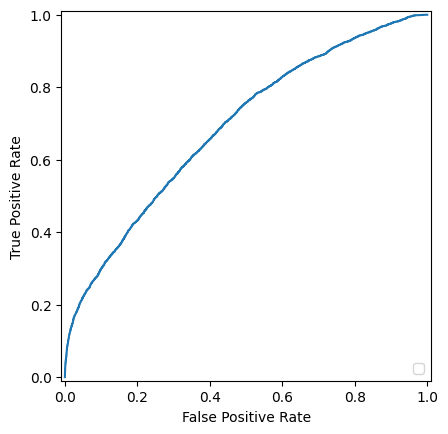

In [7]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here

fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()



In [8]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here

decision_preds = pipe_svm.decision_function(X_test)

min_pred = min(decision_preds)
max_pred = max(decision_preds)

preds_svm = [-abs(x-min_pred)/min_pred*0.5
             if x <= 0 
             else abs(x/max_pred)*0.5+0.5 
             for x in decision_preds]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


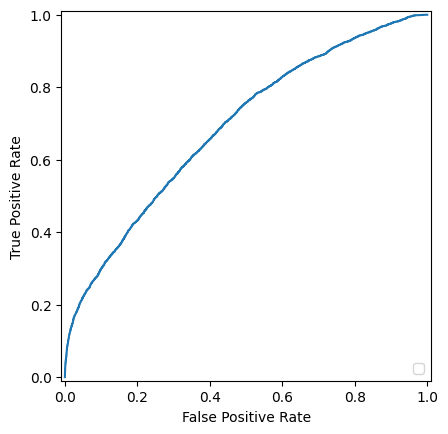

In [9]:
fpr_2, tpr_2, thresholds = roc_curve(y_test, preds_svm)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [10]:
from sklearn.metrics import auc 

### Your code is here

print("auc_svm = ", auc(fpr_2, tpr_2))
print("auc_lr = ", auc(fpr, tpr))





auc_svm =  0.6877981855211535
auc_lr =  0.6890736795540984


Построй калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

In [11]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


### Your code is here
prob_lr = pipe_lr.predict_proba(X_test)[:, 1]
b_score_lr = brier_score_loss(y_test, prob_lr)
print("Оценка Брайера:",b_score_lr)
true_lr, pred_lr = calibration_curve(y_test, prob_lr, n_bins=10)





Оценка Брайера: 0.12629320173808245


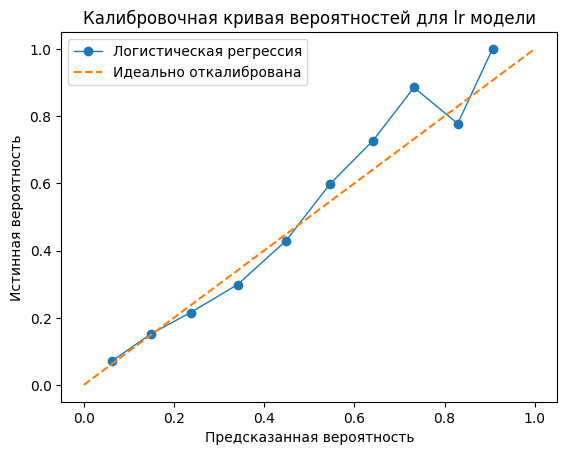

In [12]:
plt.plot(pred_lr,
true_lr,
marker='o',
linewidth=1,
label='Логистическая регрессия')
plt.plot([0, 1],
[0, 1],
linestyle='--',
label='Идеально откалибрована')
plt.title('Калибровочная кривая вероятностей для lr модели')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Истинная вероятность')
plt.legend(loc='best')
plt.show()


In [13]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

### Your code is here
b_score_svm = brier_score_loss(y_test, preds_svm)
print("Оценка Брайера:", b_score_svm)
true_svm, pred_svm = calibration_curve(y_test, preds_svm, n_bins=10)



Оценка Брайера: 0.14883229692128133


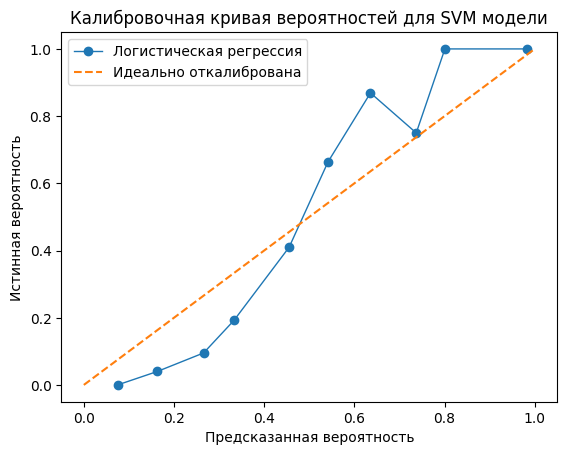

In [14]:
plt.plot(pred_svm,
true_svm,
marker='o',
linewidth=1,
label='Логистическая регрессия')
plt.plot([0, 1],
[0, 1],
linestyle='--',
label='Идеально откалибрована')
plt.title('Калибровочная кривая вероятностей для SVM модели')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Истинная вероятность')
plt.legend(loc='best')
plt.show()

Какая калибровочная кривая ближе к диагонали?

lr модель находится ближен к диагонали

In [15]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here
calibrated_lr = CalibratedClassifierCV(pipe_lr, method='sigmoid')
calibrated_lr.fit(X_train, y_train)




CalibratedClassifierCV(estimator=Pipeline(steps=[('lr_scaler', MinMaxScaler()),
                                                 ('lr_estimator',
                                                  LogisticRegression())]))

In [16]:
y_proba = calibrated_lr.predict_proba(X_test)

print("Предсказанные вероятности:", [np.argmax(prob) for prob in y_proba])

Предсказанные вероятности: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
calibrated_svm = CalibratedClassifierCV(pipe_svm, method='sigmoid')
calibrated_svm.fit(X_train, y_train)

CalibratedClassifierCV(estimator=Pipeline(steps=[('lr_scaler', MinMaxScaler()),
                                                 ('svm_estimator',
                                                  LinearSVC())]))

In [18]:
y_proba_svm = calibrated_svm.predict_proba(X_test)

print("Предсказанные вероятности:", [np.argmax(prob) for prob in y_proba_svm])

Предсказанные вероятности: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
### Новая кривая
### Your code is here



добавить новые метрики, добавить шума, 1 против всех, все против всех

In [21]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [29]:
import numpy as np
numeric_columns = data.columns


In [30]:
data.shape

(119952, 79)

In [31]:
data[numeric_columns].corr()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
EngineVersion,1.000000,0.411043,0.677000,0.001382,0.009696,0.005597,-0.066453,-0.020970,0.001528,0.005514,...,-0.011862,0.037702,-0.037805,0.013440,0.002520,-0.037495,0.003578,-0.000639,-0.014329,0.089125
AppVersion,0.411043,1.000000,0.298042,-0.012551,0.023653,0.047437,-0.095582,-0.023179,0.005808,0.010633,...,0.014282,0.047369,-0.047566,0.016836,0.005155,-0.047899,-0.023187,0.010684,-0.008030,0.076167
AvSigVersion,0.677000,0.298042,1.000000,0.003069,0.006339,0.032455,-0.079939,-0.022954,0.000729,0.006867,...,-0.012879,0.038231,-0.038369,0.012564,0.003552,-0.038383,-0.005954,0.010793,-0.008724,0.147703
RtpStateBitfield,0.001382,-0.012551,0.003069,1.000000,-0.891371,0.111674,-0.182880,-0.005451,-0.007269,0.009750,...,-0.006348,-0.013307,0.013255,0.002408,0.001710,0.013514,-0.023696,0.010494,0.005259,0.024522
IsSxsPassiveMode,0.009696,0.023653,0.006339,-0.891371,1.000000,-0.114333,0.189621,0.027478,0.014738,-0.012284,...,-0.021246,0.014427,-0.014382,-0.006337,-0.001495,-0.014694,0.028827,-0.011324,-0.005467,-0.018997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Census_OSArchitecture_x86,-0.037495,-0.047899,-0.038383,0.013514,-0.014694,0.005778,-0.068957,-0.018045,-0.054335,0.006873,...,-0.020115,-0.989211,0.989783,-0.015088,-0.003561,1.000000,-0.016032,-0.008569,0.000848,-0.051685
Census_GenuineStateName_IS_GENUINE,0.003578,-0.023187,-0.005954,-0.023696,0.028827,-0.075578,0.141847,0.020825,-0.012436,-0.016971,...,0.016894,0.016950,-0.016828,-0.019185,-0.003794,-0.016032,1.000000,-0.441070,-0.130255,0.000676
Census_GenuineStateName_OFFLINE,-0.000639,0.010684,0.010793,0.010494,-0.011324,0.048200,-0.066818,-0.007252,-0.013162,0.000077,...,0.018186,0.008358,-0.008306,-0.007003,-0.001653,-0.008569,-0.441070,1.000000,-0.007441,0.011723
Census_GenuineStateName_UNKNOWN,-0.014329,-0.008030,-0.008724,0.005259,-0.005467,0.017972,-0.025898,-0.003582,-0.001029,0.001632,...,-0.000776,0.000360,-0.000344,-0.002068,-0.000488,0.000848,-0.130255,-0.007441,1.000000,-0.009981


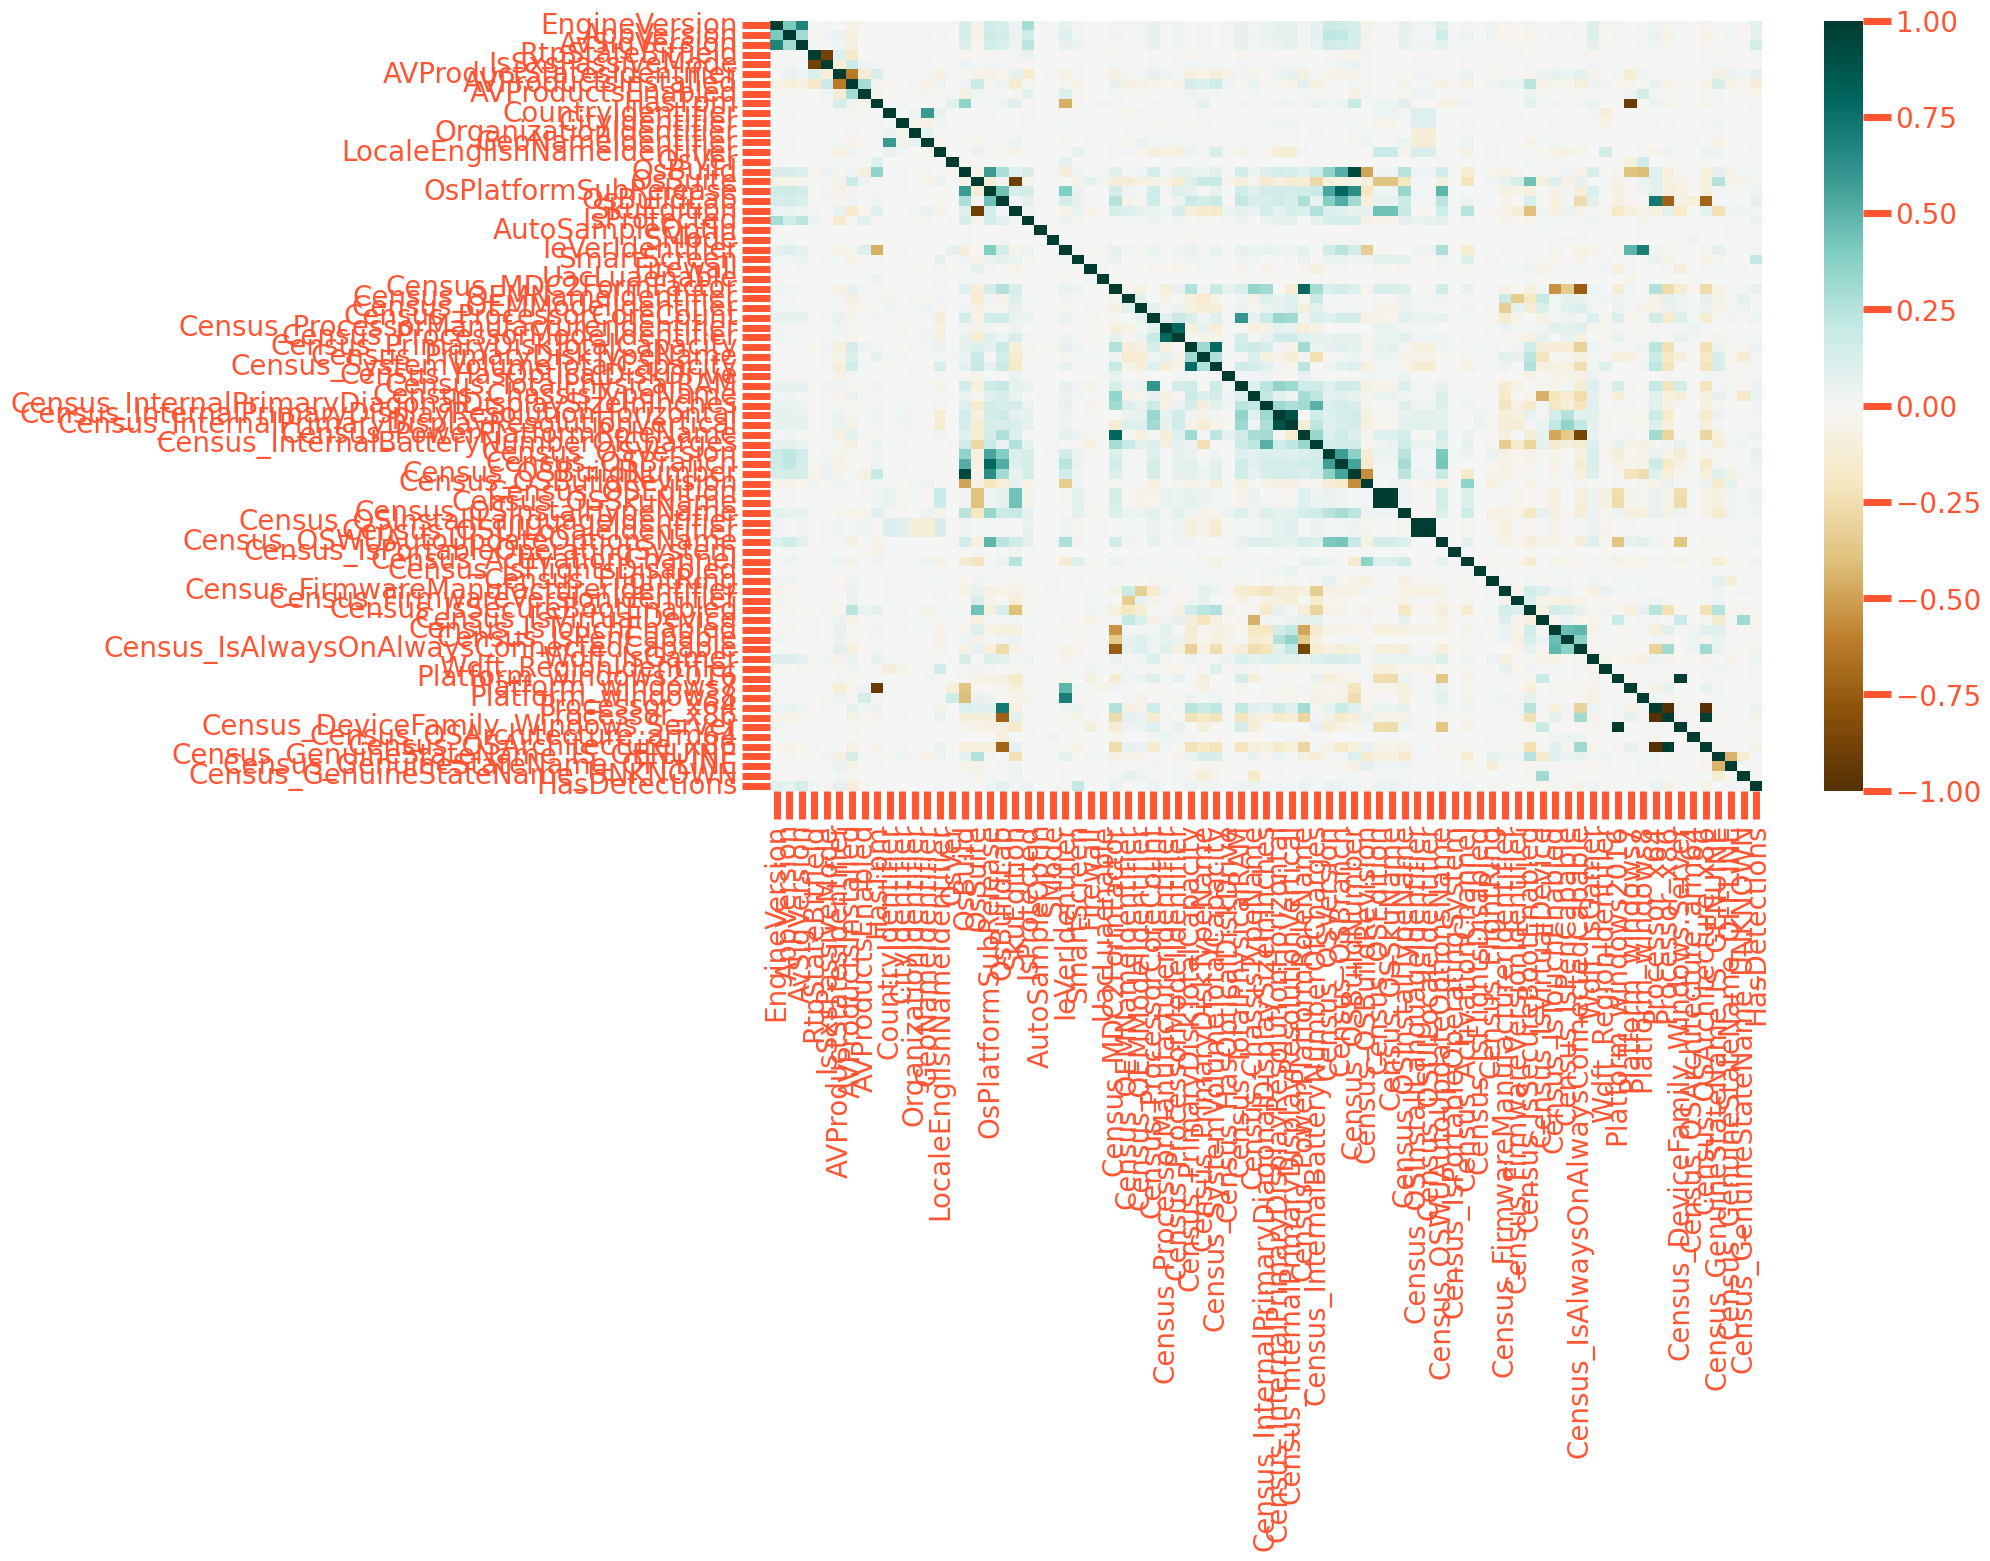

In [37]:

import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(data[numeric_columns].corr(), 
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [39]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data[numeric_columns], 10))

Top Absolute Correlations
Platform_windows2016                Census_DeviceFamily_Windows.Server    1.000000
Processor_x64                       Processor_x86                         0.999423
Census_OSEdition                    Census_OSSkuName                      0.996716
Processor_x86                       Census_OSArchitecture_x86             0.989783
Processor_x64                       Census_OSArchitecture_x86             0.989211
Census_OSInstallLanguageIdentifier  Census_OSUILocaleIdentifier           0.983752
OsBuild                             Census_OSBuildNumber                  0.937425
HasTpm                              Platform_windows7                     0.921188
OsSuite                             SkuEdition                            0.903962
RtpStateBitfield                    IsSxsPassiveMode                      0.891371
dtype: float64


In [41]:
from sklearn.feature_selection import VarianceThreshold


cutter = VarianceThreshold(threshold=0.1)
cutter.fit(data[numeric_columns])

cutter.get_feature_names_out()

array(['RtpStateBitfield', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'CountryIdentifier', 'CityIdentifier',
       'OrganizationIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite',
       'IeVerIdentifier', 'Census_OEMNameIdentifier',
       'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier',
       'Census_PrimaryDiskTotalCapacity',
       'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalPrimaryDisplayResolutionVertical',
       'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber',
       'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier',
       'Census_OSUILocaleIdentifier',
       'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionId

In [48]:
data

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119947,0.552153,0.666667,0.531401,7.0,0,53447.0,1.0,1.0,1,21,...,0,1,0,0,0,0,0,0,0,1
119948,0.552153,0.530941,0.542553,7.0,0,53447.0,1.0,1.0,1,141,...,0,1,0,0,0,0,1,0,0,1
119949,0.448751,0.420644,0.484434,7.0,0,42588.0,2.0,1.0,1,207,...,0,1,0,0,0,0,1,0,0,1
119950,0.493175,0.530941,0.537931,7.0,0,53447.0,1.0,1.0,1,68,...,0,1,0,0,0,0,1,0,0,1


In [57]:
data

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119947,0.552153,0.666667,0.531401,7.0,0,53447.0,1.0,1.0,1,21,...,0,1,0,0,0,0,0,0,0,1
119948,0.552153,0.530941,0.542553,7.0,0,53447.0,1.0,1.0,1,141,...,0,1,0,0,0,0,1,0,0,1
119949,0.448751,0.420644,0.484434,7.0,0,42588.0,2.0,1.0,1,207,...,0,1,0,0,0,0,1,0,0,1
119950,0.493175,0.530941,0.537931,7.0,0,53447.0,1.0,1.0,1,68,...,0,1,0,0,0,0,1,0,0,1


In [64]:
def encode_multiclass_target(data, category, target='CountryIdentifier'):
    data = data[[category, target]].copy()
    
    target_dummies = pd.get_dummies(data[target], 
                                    prefix=category, 
                                    drop_first=True)
    
    data = pd.concat((data, target_dummies), axis=1)
    
    for tg in target_dummies.columns:
        
        data[tg] = data.groupby(category)[tg].transform("mean")
    
    return data.drop(category, axis=1)

In [62]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [66]:
X = data.drop('CountryIdentifier', axis=1)
Y = data['CountryIdentifier']

In [67]:
Y.head()

0     29
1     93
2     86
3     97
4    164
Name: CountryIdentifier, dtype: int64

In [68]:
Y.value_counts()

CountryIdentifier
43     5349
29     4628
141    4389
93     3827
171    3720
       ... 
193       2
217       2
161       1
212       1
216       1
Name: count, Length: 222, dtype: int64

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    random_state=0, 
                                                    test_size=0.2)